In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from continuousBTSP import continuousBTSPNetwork
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# ---------------- 参数设置 ----------------
n_input = 10000   # CA3 神经元数
n_memory = 15000  # CA1 神经元数
n_patterns = 4000 # 总记忆模式数量
fq = 0.0025        # BTSP 更新概率（突触翻转概率）
fp = 0.005         # 输入稀疏度
fw = 0.6           # 连接稀疏度
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# ---------------- 初始化网络 ----------------
net = continuousBTSPNetwork(
    n_input=n_input,
    n_memory=n_memory,
    fq=fq,
    fp=fp,
    fw=fw,
    device=device,
    n_subsynapses=8,
    threshold=10
)

# ---------------- 生成稀疏输入模式 ----------------
patterns = net.make_sparse_patterns(n_patterns)  # uint8 tensor, shape (n_patterns, n_input)

# ---------------- 监控某个 CA1 神经元的突触更新 ----------------
neuron_idx = 10  # 要分析的 CA1 神经元
neuron_trained_pattern_indices = []

for i in tqdm(range(n_patterns), desc="Training patterns"):
    x = patterns[i].to(device)  # (n_input,)
    
    # 使用类内向量化 btsp_update_fast，并提前获取 neuron 更新信息
    x_tensor = x
    active_idx = torch.nonzero(x_tensor, as_tuple=True)[0]
    if active_idx.numel() == 0:
        continue

    # 当前活跃连接：shape = (n_memory, n_active, n_subsynapses)
    active_connections = net.connections[:, active_idx, :]
    has_active_connection = active_connections.any(dim=(1, 2))  # bool vector over n_memory

    # 决定哪些 neuron 需要更新
    neuron_update_mask = (torch.rand(net.n_memory, device=device) < net.fq) & has_active_connection

    # 记录目标 neuron 是否更新
    if neuron_update_mask[neuron_idx]:
        neuron_trained_pattern_indices.append(i)

    # 执行突触翻转（类内向量化）
    neuron_indices = torch.nonzero(neuron_update_mask, as_tuple=True)[0]
    if neuron_indices.numel() > 0:
        subconn = net.synaptic_strengths[neuron_indices][:, active_idx, :]  # (N_upd, n_active, n_sub)
        flip_mask = torch.rand_like(subconn) < 0.5
        net.synaptic_strengths[neuron_indices[:, None], active_idx[None, :], :] = torch.where(
            flip_mask, 1.0 - subconn, subconn
        )

# ---------------- 输出统计 ----------------
neuron_trained_pattern_indices = np.array(neuron_trained_pattern_indices, dtype=np.int64)
print(f"监控神经元 {neuron_idx} 在训练过程中发生可塑性的模式数: "
      f"{len(neuron_trained_pattern_indices)} / {n_patterns}")


使用设备: cuda


Training patterns: 100%|██████████| 4000/4000 [00:13<00:00, 296.15it/s]

监控神经元 10 在训练过程中发生可塑性的模式数: 8 / 4000


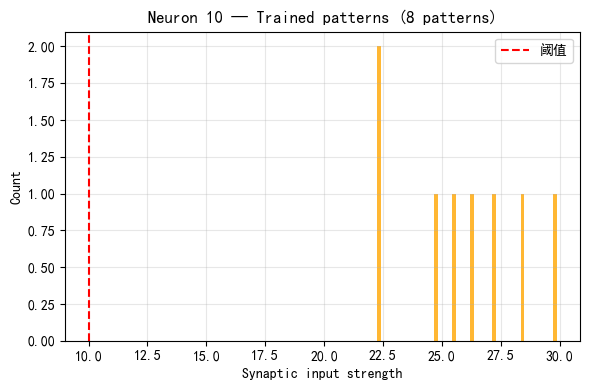

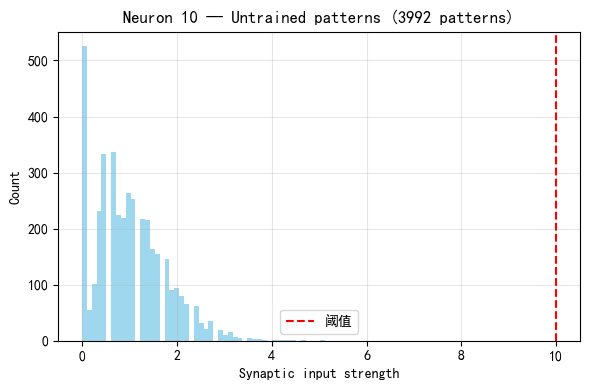

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_btsp_input_distribution(network, patterns, trained_indices, neuron_idx=0, bins=50):
    """
    绘制单个 CA1 神经元对所有模式的输入加和分布（连续 BTSP 版本）
    - network: continuousBTSPNetwork
    - patterns: 所有输入模式 (torch.Tensor, shape [n_patterns, n_input])
    - trained_indices: list/array，哪些模式被 neuron 训练（发生可塑性）
    - neuron_idx: 要查看的 CA1 神经元索引
    """
    # 转到正确设备
    patterns = patterns.to(network.device).float()  # shape: [n_patterns, n_input]
    
    # 取出该神经元的突触权重向量 (平均所有子突触)
    weights = network.synaptic_strengths[neuron_idx].mean(dim=1)  # shape = [n_input]

    # 计算所有模式的输入加和
    input_sums = (patterns @ weights).detach().cpu().numpy()  # shape = [n_patterns]

    # 划分已训练和未训练模式
    trained_mask = np.zeros(len(patterns), dtype=bool)
    trained_mask[trained_indices] = True

    trained_inputs = input_sums[trained_mask]     # 已训练模式
    untrained_inputs = input_sums[~trained_mask]  # 未训练模式

    # ---------------- 绘图 ----------------
    # 1️⃣ 训练模式分布
    plt.figure(figsize=(6, 4))
    plt.hist(trained_inputs, bins=bins, color='orange', alpha=0.8)
    plt.axvline(network.threshold[neuron_idx].item(), color='red', linestyle='--', label='阈值')
    plt.xlabel("Synaptic input strength")
    plt.ylabel("Count")
    plt.title(f"Neuron {neuron_idx} — Trained patterns ({len(trained_inputs)} patterns)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2️⃣ 未训练模式分布
    plt.figure(figsize=(6, 4))
    plt.hist(untrained_inputs, bins=bins, color='skyblue', alpha=0.8)
    plt.axvline(network.threshold[neuron_idx].item(), color='red', linestyle='--', label='阈值')
    plt.xlabel("Synaptic input strength")
    plt.ylabel("Count")
    plt.title(f"Neuron {neuron_idx} — Untrained patterns ({len(untrained_inputs)} patterns)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return trained_inputs, untrained_inputs

trained_inputs, untrained_inputs = plot_btsp_input_distribution(
    net, patterns, neuron_trained_pattern_indices, neuron_idx=neuron_idx
)

